In [1]:
from torchvision.models.feature_extraction import create_feature_extractor
from torchvision.models import resnet18

import torch

from tqdm import tqdm

from utils.dataset import Dataset

In [2]:
batch_size = 1000

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# loading dataset + creating train test split for verifying performance
dataset = Dataset("gaze-dataset")

train_set, val_set = torch.utils.data.random_split(dataset, [10000, 1382])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True)

Loading dataset sample names...
Training images: 11382


In [5]:
sample = next(iter(train_loader))
print(sample[0][0].shape)

torch.Size([1, 36, 60])


In [6]:
class RegressionHead(torch.nn.Module):
    def __init__(self):
        super(RegressionHead, self).__init__()

        self.conv1 = torch.nn.Conv2d(1, 20, 5)
        self.conv2 = torch.nn.Conv2d(20, 50, 5)
        self.conv3 = torch.nn.Conv2d(50, 100, 3)

        self.linear1 = torch.nn.Linear(4000, 500)
        self.linear2 = torch.nn.Linear(509, 2)

        self.pool = torch.nn.MaxPool2d(2)

        self.flatten = torch.nn.Flatten()

    def forward(self, x):
        image, head_pos = x

        output = self.conv1(image)
        output = self.pool(output)
        output = self.conv2(output)
        output = self.pool(output)
        output = self.conv3(output)

        output = self.flatten(output)

        output = self.linear1(output)
        output = torch.hstack((output, self.flatten(head_pos)))

        return self.linear2(output)

In [7]:
regression_head = RegressionHead().to(device)
regression_head.to(device)

RegressionHead(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(50, 100, kernel_size=(3, 3), stride=(1, 1))
  (linear1): Linear(in_features=4000, out_features=500, bias=True)
  (linear2): Linear(in_features=509, out_features=2, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

In [8]:
EPOCHS = 200

criterion = torch.nn.MSELoss() 
optimizer = torch.optim.Adam(regression_head.parameters(), lr=1e-3)

In [9]:
losses = []
val_losses = []

for epoch in range(EPOCHS):
    print("Epoch: " + str(epoch))
    for i, (inputs, targets, head_pose) in tqdm(enumerate(train_loader), total=int(10000/batch_size)+1):
        optimizer.zero_grad()
        
        inputs = inputs.to(device)

        output = regression_head((inputs, head_pose.to(device)))

        loss = criterion(output, targets.to(device))
        
        if i == len(train_loader)-1:
            print("Train loss: " + str(loss.item()))
            losses.append(loss.item())

        loss.backward()
        
        optimizer.step()
    
    for i, (inputs, targets, head_pose) in tqdm(enumerate(val_loader), total=int(1382/batch_size)+1):
        inputs = inputs.to(device)

        output = regression_head((inputs, head_pose.to(device)))

        loss = criterion(output, targets.to(device))
        
        if i == len(val_loader)-1:
            print("Val loss: " + str(loss.item()))
            val_losses.append(loss.item())

Epoch: 0


 91%|█████████ | 10/11 [00:08<00:00,  1.17it/s]


Train loss: 0.12798474729061127


100%|██████████| 2/2 [00:00<00:00,  2.05it/s]


Val loss: 0.24023665487766266
Epoch: 1


 91%|█████████ | 10/11 [00:07<00:00,  1.42it/s]


Train loss: 0.09432211518287659


100%|██████████| 2/2 [00:00<00:00,  2.06it/s]


Val loss: 0.1030704453587532
Epoch: 2


 91%|█████████ | 10/11 [00:07<00:00,  1.42it/s]


Train loss: 0.08721432834863663


100%|██████████| 2/2 [00:00<00:00,  2.06it/s]


Val loss: 0.07861536741256714
Epoch: 3


 91%|█████████ | 10/11 [00:07<00:00,  1.40it/s]


Train loss: 0.06487591564655304


100%|██████████| 2/2 [00:00<00:00,  2.05it/s]


Val loss: 0.06306616216897964
Epoch: 4


 91%|█████████ | 10/11 [00:06<00:00,  1.43it/s]


Train loss: 0.05464114248752594


100%|██████████| 2/2 [00:00<00:00,  2.05it/s]


Val loss: 0.054305002093315125
Epoch: 5


 91%|█████████ | 10/11 [00:07<00:00,  1.42it/s]


Train loss: 0.05275863781571388


100%|██████████| 2/2 [00:00<00:00,  2.05it/s]


Val loss: 0.046585679054260254
Epoch: 6


 91%|█████████ | 10/11 [00:07<00:00,  1.41it/s]


Train loss: 0.04586765542626381


100%|██████████| 2/2 [00:00<00:00,  2.07it/s]


Val loss: 0.04617910832166672
Epoch: 7


 91%|█████████ | 10/11 [00:07<00:00,  1.42it/s]


Train loss: 0.045357752591371536


100%|██████████| 2/2 [00:00<00:00,  2.05it/s]


Val loss: 0.047789350152015686
Epoch: 8


 91%|█████████ | 10/11 [00:07<00:00,  1.42it/s]


Train loss: 0.041415512561798096


100%|██████████| 2/2 [00:00<00:00,  2.05it/s]


Val loss: 0.04273078218102455
Epoch: 9


 91%|█████████ | 10/11 [00:07<00:00,  1.40it/s]


Train loss: 0.040074173361063004


100%|██████████| 2/2 [00:00<00:00,  2.04it/s]


Val loss: 0.04179180786013603
Epoch: 10


 91%|█████████ | 10/11 [00:07<00:00,  1.40it/s]


Train loss: 0.03909699618816376


100%|██████████| 2/2 [00:00<00:00,  2.04it/s]


Val loss: 0.037812817841768265
Epoch: 11


 91%|█████████ | 10/11 [00:07<00:00,  1.43it/s]


Train loss: 0.037582919001579285


100%|██████████| 2/2 [00:00<00:00,  2.06it/s]


Val loss: 0.03907126933336258
Epoch: 12


 91%|█████████ | 10/11 [00:07<00:00,  1.40it/s]


Train loss: 0.03827226534485817


100%|██████████| 2/2 [00:00<00:00,  2.04it/s]


Val loss: 0.03561483323574066
Epoch: 13


 91%|█████████ | 10/11 [00:07<00:00,  1.43it/s]


Train loss: 0.03577371686697006


100%|██████████| 2/2 [00:00<00:00,  2.05it/s]


Val loss: 0.03644704446196556
Epoch: 14


 91%|█████████ | 10/11 [00:07<00:00,  1.42it/s]


Train loss: 0.03357338905334473


100%|██████████| 2/2 [00:00<00:00,  2.05it/s]


Val loss: 0.03425528109073639
Epoch: 15


 91%|█████████ | 10/11 [00:07<00:00,  1.41it/s]


Train loss: 0.032206300646066666


100%|██████████| 2/2 [00:00<00:00,  2.07it/s]


Val loss: 0.03284512832760811
Epoch: 16


 91%|█████████ | 10/11 [00:07<00:00,  1.43it/s]


Train loss: 0.032840654253959656


100%|██████████| 2/2 [00:00<00:00,  2.05it/s]


Val loss: 0.030466793105006218
Epoch: 17


 91%|█████████ | 10/11 [00:07<00:00,  1.42it/s]


Train loss: 0.03066193126142025


100%|██████████| 2/2 [00:00<00:00,  2.05it/s]


Val loss: 0.030731750652194023
Epoch: 18


 91%|█████████ | 10/11 [00:07<00:00,  1.41it/s]


Train loss: 0.029719602316617966


100%|██████████| 2/2 [00:00<00:00,  2.04it/s]


Val loss: 0.030447054654359818
Epoch: 19


 91%|█████████ | 10/11 [00:07<00:00,  1.42it/s]


Train loss: 0.02885296382009983


100%|██████████| 2/2 [00:00<00:00,  2.06it/s]


Val loss: 0.03068031743168831
Epoch: 20


 91%|█████████ | 10/11 [00:07<00:00,  1.41it/s]


Train loss: 0.030434781685471535


100%|██████████| 2/2 [00:00<00:00,  2.04it/s]


Val loss: 0.027866309508681297
Epoch: 21


 91%|█████████ | 10/11 [00:07<00:00,  1.43it/s]


Train loss: 0.027357477694749832


100%|██████████| 2/2 [00:00<00:00,  2.05it/s]


Val loss: 0.028993086889386177
Epoch: 22


 91%|█████████ | 10/11 [00:07<00:00,  1.42it/s]


Train loss: 0.027209118008613586


100%|██████████| 2/2 [00:00<00:00,  2.06it/s]


Val loss: 0.028165850788354874
Epoch: 23


 91%|█████████ | 10/11 [00:07<00:00,  1.41it/s]


Train loss: 0.02517593465745449


100%|██████████| 2/2 [00:00<00:00,  2.05it/s]


Val loss: 0.025996802374720573
Epoch: 24


 91%|█████████ | 10/11 [00:07<00:00,  1.42it/s]


Train loss: 0.028107304126024246


100%|██████████| 2/2 [00:00<00:00,  2.06it/s]


Val loss: 0.02646578662097454
Epoch: 25


 91%|█████████ | 10/11 [00:07<00:00,  1.43it/s]


Train loss: 0.026954511180520058


100%|██████████| 2/2 [00:00<00:00,  2.05it/s]


Val loss: 0.02726682648062706
Epoch: 26


 91%|█████████ | 10/11 [00:07<00:00,  1.40it/s]


Train loss: 0.02545987442135811


100%|██████████| 2/2 [00:00<00:00,  2.05it/s]


Val loss: 0.02617538347840309
Epoch: 27


 91%|█████████ | 10/11 [00:07<00:00,  1.43it/s]


Train loss: 0.02507620118558407


100%|██████████| 2/2 [00:00<00:00,  2.04it/s]


Val loss: 0.025778107345104218
Epoch: 28


 91%|█████████ | 10/11 [00:07<00:00,  1.42it/s]


Train loss: 0.025080662220716476


100%|██████████| 2/2 [00:00<00:00,  2.06it/s]


Val loss: 0.024223802611231804
Epoch: 29


 91%|█████████ | 10/11 [00:07<00:00,  1.41it/s]


Train loss: 0.02179718017578125


100%|██████████| 2/2 [00:00<00:00,  2.05it/s]


Val loss: 0.024640396237373352
Epoch: 30


 91%|█████████ | 10/11 [00:07<00:00,  1.42it/s]


Train loss: 0.02416910231113434


100%|██████████| 2/2 [00:00<00:00,  2.06it/s]


Val loss: 0.0255156047642231
Epoch: 31


 91%|█████████ | 10/11 [00:07<00:00,  1.42it/s]


Train loss: 0.02437378466129303


100%|██████████| 2/2 [00:00<00:00,  2.05it/s]


Val loss: 0.022806473076343536
Epoch: 32


 91%|█████████ | 10/11 [00:07<00:00,  1.40it/s]


Train loss: 0.02196347527205944


100%|██████████| 2/2 [00:00<00:00,  2.04it/s]


Val loss: 0.023366320878267288
Epoch: 33


 91%|█████████ | 10/11 [00:07<00:00,  1.43it/s]


Train loss: 0.022938834503293037


100%|██████████| 2/2 [00:00<00:00,  2.05it/s]


Val loss: 0.02211190201342106
Epoch: 34


 91%|█████████ | 10/11 [00:07<00:00,  1.42it/s]


Train loss: 0.022095613181591034


100%|██████████| 2/2 [00:00<00:00,  2.05it/s]


Val loss: 0.023576701059937477
Epoch: 35


 91%|█████████ | 10/11 [00:07<00:00,  1.40it/s]


Train loss: 0.02219999022781849


100%|██████████| 2/2 [00:00<00:00,  2.05it/s]


Val loss: 0.024188775569200516
Epoch: 36


 91%|█████████ | 10/11 [00:07<00:00,  1.42it/s]


Train loss: 0.02160666696727276


100%|██████████| 2/2 [00:00<00:00,  2.04it/s]


Val loss: 0.021233443170785904
Epoch: 37


 91%|█████████ | 10/11 [00:07<00:00,  1.41it/s]


Train loss: 0.02117966115474701


100%|██████████| 2/2 [00:00<00:00,  2.05it/s]


Val loss: 0.02196411043405533
Epoch: 38


 91%|█████████ | 10/11 [00:07<00:00,  1.40it/s]


Train loss: 0.021472565829753876


100%|██████████| 2/2 [00:00<00:00,  2.06it/s]


Val loss: 0.021427404135465622
Epoch: 39


 91%|█████████ | 10/11 [00:07<00:00,  1.43it/s]


Train loss: 0.02175302617251873


100%|██████████| 2/2 [00:00<00:00,  2.09it/s]


Val loss: 0.022073989734053612
Epoch: 40


 91%|█████████ | 10/11 [00:07<00:00,  1.42it/s]


Train loss: 0.0208885557949543


100%|██████████| 2/2 [00:00<00:00,  2.06it/s]


Val loss: 0.020858917385339737
Epoch: 41


 91%|█████████ | 10/11 [00:07<00:00,  1.40it/s]


Train loss: 0.0211492870002985


100%|██████████| 2/2 [00:00<00:00,  2.03it/s]


Val loss: 0.022464649751782417
Epoch: 42


 91%|█████████ | 10/11 [00:07<00:00,  1.41it/s]


Train loss: 0.019587615504860878


100%|██████████| 2/2 [00:00<00:00,  2.03it/s]


Val loss: 0.02288665622472763
Epoch: 43


 91%|█████████ | 10/11 [00:07<00:00,  1.42it/s]


Train loss: 0.018726544454693794


100%|██████████| 2/2 [00:00<00:00,  2.05it/s]


Val loss: 0.02013946883380413
Epoch: 44


 91%|█████████ | 10/11 [00:07<00:00,  1.41it/s]


Train loss: 0.019148247316479683


100%|██████████| 2/2 [00:00<00:00,  2.05it/s]


Val loss: 0.02011849172413349
Epoch: 45


 91%|█████████ | 10/11 [00:07<00:00,  1.42it/s]


Train loss: 0.018394337967038155


100%|██████████| 2/2 [00:00<00:00,  2.05it/s]


Val loss: 0.02050347812473774
Epoch: 46


 91%|█████████ | 10/11 [00:07<00:00,  1.42it/s]


Train loss: 0.01886262744665146


100%|██████████| 2/2 [00:00<00:00,  2.05it/s]


Val loss: 0.021037612110376358
Epoch: 47


 91%|█████████ | 10/11 [00:07<00:00,  1.41it/s]


Train loss: 0.019560420885682106


100%|██████████| 2/2 [00:00<00:00,  2.05it/s]


Val loss: 0.021106526255607605
Epoch: 48


 91%|█████████ | 10/11 [00:07<00:00,  1.42it/s]


Train loss: 0.019097479060292244


100%|██████████| 2/2 [00:00<00:00,  2.06it/s]


Val loss: 0.02185588888823986
Epoch: 49


 91%|█████████ | 10/11 [00:07<00:00,  1.42it/s]


Train loss: 0.018450332805514336


100%|██████████| 2/2 [00:00<00:00,  2.04it/s]


Val loss: 0.019162846729159355
Epoch: 50


 91%|█████████ | 10/11 [00:07<00:00,  1.41it/s]


Train loss: 0.01855200156569481


100%|██████████| 2/2 [00:00<00:00,  2.07it/s]


Val loss: 0.01933743618428707
Epoch: 51


 91%|█████████ | 10/11 [00:07<00:00,  1.42it/s]


Train loss: 0.018168721348047256


100%|██████████| 2/2 [00:00<00:00,  2.05it/s]


Val loss: 0.019929934293031693
Epoch: 52


 91%|█████████ | 10/11 [00:07<00:00,  1.43it/s]


Train loss: 0.018229564651846886


100%|██████████| 2/2 [00:00<00:00,  2.05it/s]


Val loss: 0.02210126258432865
Epoch: 53


 91%|█████████ | 10/11 [00:07<00:00,  1.41it/s]


Train loss: 0.01722816564142704


100%|██████████| 2/2 [00:00<00:00,  2.05it/s]


Val loss: 0.021119408309459686
Epoch: 54


 91%|█████████ | 10/11 [00:07<00:00,  1.42it/s]


Train loss: 0.017072273418307304


100%|██████████| 2/2 [00:00<00:00,  2.05it/s]


Val loss: 0.0188789963722229
Epoch: 55


 91%|█████████ | 10/11 [00:07<00:00,  1.42it/s]


Train loss: 0.017590932548046112


100%|██████████| 2/2 [00:00<00:00,  2.06it/s]


Val loss: 0.018672188743948936
Epoch: 56


 91%|█████████ | 10/11 [00:07<00:00,  1.41it/s]


Train loss: 0.017393052577972412


100%|██████████| 2/2 [00:00<00:00,  2.04it/s]


Val loss: 0.01851469837129116
Epoch: 57


 91%|█████████ | 10/11 [00:07<00:00,  1.41it/s]


Train loss: 0.017585519701242447


100%|██████████| 2/2 [00:00<00:00,  2.04it/s]


Val loss: 0.01847514882683754
Epoch: 58


 91%|█████████ | 10/11 [00:07<00:00,  1.42it/s]


Train loss: 0.017893068492412567


100%|██████████| 2/2 [00:00<00:00,  2.06it/s]


Val loss: 0.016635730862617493
Epoch: 59


 91%|█████████ | 10/11 [00:07<00:00,  1.41it/s]


Train loss: 0.01689200848340988


100%|██████████| 2/2 [00:00<00:00,  2.05it/s]


Val loss: 0.017164545133709908
Epoch: 60


 91%|█████████ | 10/11 [00:07<00:00,  1.42it/s]


Train loss: 0.016471505165100098


100%|██████████| 2/2 [00:00<00:00,  2.06it/s]


Val loss: 0.021068323403596878
Epoch: 61


 91%|█████████ | 10/11 [00:07<00:00,  1.42it/s]


Train loss: 0.016765527427196503


100%|██████████| 2/2 [00:00<00:00,  2.07it/s]


Val loss: 0.017376461997628212
Epoch: 62


 91%|█████████ | 10/11 [00:07<00:00,  1.41it/s]


Train loss: 0.0162962656468153


100%|██████████| 2/2 [00:00<00:00,  2.04it/s]


Val loss: 0.018268678337335587
Epoch: 63


 91%|█████████ | 10/11 [00:07<00:00,  1.43it/s]


Train loss: 0.01605006493628025


100%|██████████| 2/2 [00:00<00:00,  2.04it/s]


Val loss: 0.019113970920443535
Epoch: 64


 91%|█████████ | 10/11 [00:07<00:00,  1.40it/s]


Train loss: 0.017681077122688293


100%|██████████| 2/2 [00:00<00:00,  2.04it/s]


Val loss: 0.01716732047498226
Epoch: 65


 91%|█████████ | 10/11 [00:07<00:00,  1.42it/s]


Train loss: 0.0164154265075922


100%|██████████| 2/2 [00:00<00:00,  2.04it/s]


Val loss: 0.0171438567340374
Epoch: 66


 91%|█████████ | 10/11 [00:07<00:00,  1.42it/s]


Train loss: 0.016081131994724274


100%|██████████| 2/2 [00:00<00:00,  2.04it/s]


Val loss: 0.018860770389437675
Epoch: 67


 91%|█████████ | 10/11 [00:07<00:00,  1.41it/s]


Train loss: 0.016673382371664047


100%|██████████| 2/2 [00:00<00:00,  2.07it/s]


Val loss: 0.01668676547706127
Epoch: 68


 91%|█████████ | 10/11 [00:07<00:00,  1.42it/s]


Train loss: 0.01531889382749796


100%|██████████| 2/2 [00:00<00:00,  2.05it/s]


Val loss: 0.016583453863859177
Epoch: 69


 91%|█████████ | 10/11 [00:07<00:00,  1.42it/s]


Train loss: 0.015032556839287281


100%|██████████| 2/2 [00:00<00:00,  2.05it/s]


Val loss: 0.017676156014204025
Epoch: 70


 91%|█████████ | 10/11 [00:07<00:00,  1.40it/s]


Train loss: 0.014715088531374931


100%|██████████| 2/2 [00:00<00:00,  2.05it/s]


Val loss: 0.015194470062851906
Epoch: 71


 91%|█████████ | 10/11 [00:07<00:00,  1.42it/s]


Train loss: 0.015927597880363464


100%|██████████| 2/2 [00:00<00:00,  2.05it/s]


Val loss: 0.017301693558692932
Epoch: 72


 91%|█████████ | 10/11 [00:07<00:00,  1.42it/s]


Train loss: 0.015080456621944904


100%|██████████| 2/2 [00:00<00:00,  2.03it/s]


Val loss: 0.01894388161599636
Epoch: 73


 91%|█████████ | 10/11 [00:07<00:00,  1.41it/s]


Train loss: 0.014563334174454212


100%|██████████| 2/2 [00:00<00:00,  2.06it/s]


Val loss: 0.01815173588693142
Epoch: 74


 91%|█████████ | 10/11 [00:07<00:00,  1.42it/s]


Train loss: 0.014453073032200336


100%|██████████| 2/2 [00:00<00:00,  2.06it/s]


Val loss: 0.015218429267406464
Epoch: 75


 91%|█████████ | 10/11 [00:07<00:00,  1.42it/s]


Train loss: 0.016129253432154655


100%|██████████| 2/2 [00:00<00:00,  2.04it/s]


Val loss: 0.01648123748600483
Epoch: 76


 91%|█████████ | 10/11 [00:07<00:00,  1.40it/s]


Train loss: 0.015759969130158424


100%|██████████| 2/2 [00:00<00:00,  2.05it/s]


Val loss: 0.016591370105743408
Epoch: 77


 91%|█████████ | 10/11 [00:07<00:00,  1.42it/s]


Train loss: 0.015032886527478695


100%|██████████| 2/2 [00:00<00:00,  2.06it/s]


Val loss: 0.015529467724263668
Epoch: 78


 91%|█████████ | 10/11 [00:07<00:00,  1.42it/s]


Train loss: 0.014667818322777748


100%|██████████| 2/2 [00:01<00:00,  2.00it/s]


Val loss: 0.018551986664533615
Epoch: 79


 91%|█████████ | 10/11 [00:07<00:00,  1.41it/s]


Train loss: 0.014603431336581707


100%|██████████| 2/2 [00:00<00:00,  2.07it/s]


Val loss: 0.017405426129698753
Epoch: 80


 91%|█████████ | 10/11 [00:07<00:00,  1.43it/s]


Train loss: 0.014209986664354801


100%|██████████| 2/2 [00:00<00:00,  2.06it/s]


Val loss: 0.017603615298867226
Epoch: 81


 91%|█████████ | 10/11 [00:07<00:00,  1.43it/s]


Train loss: 0.014128000475466251


100%|██████████| 2/2 [00:00<00:00,  2.05it/s]


Val loss: 0.01616309955716133
Epoch: 82


 91%|█████████ | 10/11 [00:07<00:00,  1.41it/s]


Train loss: 0.014276894740760326


100%|██████████| 2/2 [00:00<00:00,  2.07it/s]


Val loss: 0.01546833012253046
Epoch: 83


 91%|█████████ | 10/11 [00:07<00:00,  1.42it/s]


Train loss: 0.013583742082118988


100%|██████████| 2/2 [00:00<00:00,  2.04it/s]


Val loss: 0.01533370092511177
Epoch: 84


 91%|█████████ | 10/11 [00:07<00:00,  1.42it/s]


Train loss: 0.013924411498010159


100%|██████████| 2/2 [00:00<00:00,  2.07it/s]


Val loss: 0.015796588733792305
Epoch: 85


 91%|█████████ | 10/11 [00:07<00:00,  1.41it/s]


Train loss: 0.014248144812881947


100%|██████████| 2/2 [00:00<00:00,  2.05it/s]


Val loss: 0.01587948203086853
Epoch: 86


 91%|█████████ | 10/11 [00:07<00:00,  1.42it/s]


Train loss: 0.015053141862154007


100%|██████████| 2/2 [00:00<00:00,  2.03it/s]


Val loss: 0.017164450138807297
Epoch: 87


 91%|█████████ | 10/11 [00:07<00:00,  1.42it/s]


Train loss: 0.014974890276789665


100%|██████████| 2/2 [00:00<00:00,  2.06it/s]


Val loss: 0.016186125576496124
Epoch: 88


 91%|█████████ | 10/11 [00:07<00:00,  1.40it/s]


Train loss: 0.01362746674567461


100%|██████████| 2/2 [00:00<00:00,  2.04it/s]


Val loss: 0.016286473721265793
Epoch: 89


 91%|█████████ | 10/11 [00:07<00:00,  1.42it/s]


Train loss: 0.01406557485461235


100%|██████████| 2/2 [00:00<00:00,  2.06it/s]


Val loss: 0.016499528661370277
Epoch: 90


 91%|█████████ | 10/11 [00:07<00:00,  1.43it/s]


Train loss: 0.01430652104318142


100%|██████████| 2/2 [00:00<00:00,  2.07it/s]


Val loss: 0.01768951490521431
Epoch: 91


 91%|█████████ | 10/11 [00:07<00:00,  1.41it/s]


Train loss: 0.01300695352256298


100%|██████████| 2/2 [00:00<00:00,  2.05it/s]


Val loss: 0.016940388828516006
Epoch: 92


 91%|█████████ | 10/11 [00:07<00:00,  1.43it/s]


Train loss: 0.012877990491688251


100%|██████████| 2/2 [00:00<00:00,  2.05it/s]


Val loss: 0.01487051509320736
Epoch: 93


 91%|█████████ | 10/11 [00:07<00:00,  1.42it/s]


Train loss: 0.013031971640884876


100%|██████████| 2/2 [00:00<00:00,  2.05it/s]


Val loss: 0.01431389432400465
Epoch: 94


 91%|█████████ | 10/11 [00:07<00:00,  1.41it/s]


Train loss: 0.013246695511043072


100%|██████████| 2/2 [00:00<00:00,  2.05it/s]


Val loss: 0.015795482322573662
Epoch: 95


 91%|█████████ | 10/11 [00:07<00:00,  1.41it/s]


Train loss: 0.013652786612510681


100%|██████████| 2/2 [00:00<00:00,  2.04it/s]


Val loss: 0.01618642546236515
Epoch: 96


 91%|█████████ | 10/11 [00:06<00:00,  1.43it/s]


Train loss: 0.012758951634168625


100%|██████████| 2/2 [00:00<00:00,  2.06it/s]


Val loss: 0.015959065407514572
Epoch: 97


 91%|█████████ | 10/11 [00:07<00:00,  1.41it/s]


Train loss: 0.013255000114440918


100%|██████████| 2/2 [00:00<00:00,  2.05it/s]


Val loss: 0.014594071544706821
Epoch: 98


 91%|█████████ | 10/11 [00:07<00:00,  1.41it/s]


Train loss: 0.01228447537869215


100%|██████████| 2/2 [00:00<00:00,  2.03it/s]


Val loss: 0.01599065028131008
Epoch: 99


 91%|█████████ | 10/11 [00:07<00:00,  1.42it/s]


Train loss: 0.012754197232425213


100%|██████████| 2/2 [00:00<00:00,  2.05it/s]


Val loss: 0.015202400274574757
Epoch: 100


 91%|█████████ | 10/11 [00:07<00:00,  1.40it/s]


Train loss: 0.01288045383989811


100%|██████████| 2/2 [00:00<00:00,  2.04it/s]


Val loss: 0.01708977296948433
Epoch: 101


 91%|█████████ | 10/11 [00:07<00:00,  1.42it/s]


Train loss: 0.014186562970280647


100%|██████████| 2/2 [00:00<00:00,  2.05it/s]


Val loss: 0.014229722321033478
Epoch: 102


 91%|█████████ | 10/11 [00:06<00:00,  1.43it/s]


Train loss: 0.012962892651557922


100%|██████████| 2/2 [00:00<00:00,  2.05it/s]


Val loss: 0.0156690813601017
Epoch: 103


 91%|█████████ | 10/11 [00:07<00:00,  1.41it/s]


Train loss: 0.012967203743755817


100%|██████████| 2/2 [00:00<00:00,  2.05it/s]


Val loss: 0.01572972722351551
Epoch: 104


 91%|█████████ | 10/11 [00:07<00:00,  1.42it/s]


Train loss: 0.012402845546603203


100%|██████████| 2/2 [00:00<00:00,  2.06it/s]


Val loss: 0.016206789761781693
Epoch: 105


 91%|█████████ | 10/11 [00:07<00:00,  1.42it/s]


Train loss: 0.012592547573149204


100%|██████████| 2/2 [00:00<00:00,  2.04it/s]


Val loss: 0.014985623769462109
Epoch: 106


 64%|██████▎   | 7/11 [00:05<00:02,  1.34it/s]


KeyboardInterrupt: 

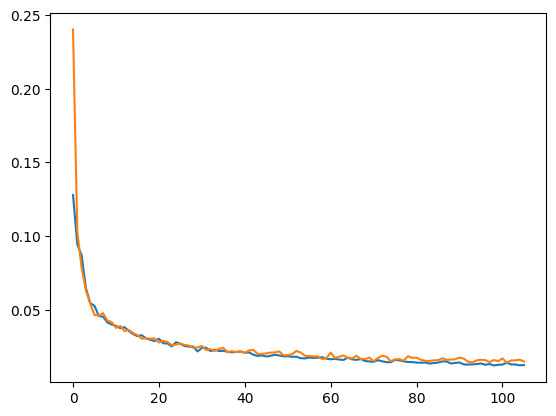

In [10]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.plot(val_losses)

In [11]:
import numpy as np

differences = []

for i, (inputs, targets, head_pose) in tqdm(enumerate(val_loader), total=int(1130/batch_size)+1):
    inputs = inputs.to(device)

    output = regression_head((inputs, head_pose.to(device)))

    if len(differences) == 0:
        differences = np.abs(targets.numpy() - output.detach().cpu().numpy())
    else:
        differences = np.vstack((differences, np.abs(targets.numpy() - output.detach().cpu().numpy())))

    print(np.mean(differences, axis=0))

 50%|█████     | 1/2 [00:00<00:00,  1.41it/s]

[0.10616804 0.08414487]


100%|██████████| 2/2 [00:00<00:00,  2.04it/s]

[0.10420512 0.08403835]
